In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline
pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
pl.rcParams['xtick.labelsize'] = 7
pl.rcParams['ytick.labelsize'] = 7
pl.rcParams['axes.labelsize'] = 7

# needs to find the library of functions
sys.path.append('../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'similarity_SSO_day2'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
vars_SS = {}
folder = '../sucroseAndShock/notebooks/autorestore/preprocessing_SucroseAndShock/'
for var in ('time_ax', 'time_ax_single','events', 'cycles','licks',
            'CYCLE_START', 'ANALYSIS_WINDOW',
            'US_START', 'US_DURATION',
            'is_rewardt', 'is_shockt'): 
    vars_SS.update({var:ut.load_variable(var, folder=folder)})
    
vars_O = {}
folder = '../odors/notebooks/autorestore/preprocessing_Odors/'
for var in ('time_ax', 'time_ax_single','events', 'cycles','licks',
            'CYCLE_START', 'ANALYSIS_WINDOW',
            'US_START', 'US_DURATION',
            'is_femalet', 'is_coyotet'): 
    vars_O.update({var:ut.load_variable(var, folder=folder)})

In [6]:
vars_SS.keys()

['US_DURATION',
 'licks',
 'time_ax',
 'time_ax_single',
 'CYCLE_START',
 'ANALYSIS_WINDOW',
 'is_rewardt',
 'US_START',
 'cycles',
 'is_shockt',
 'events']

In [8]:
input_CellReg_filename = '../../data/CellReg/SSO_day2/cellreg.txt'

In [9]:
output_filename = input_CellReg_filename.split('.')[0]+'cellregSSO_dict.txt'
with open(input_CellReg_filename, 'r') as f:
    header = f.readline()
sessions = header.split()[1:]
cellreg = np.loadtxt(input_CellReg_filename)

#cellreg_dict = dict(zip(sessions, [map(int, c) for c in cellreg.T]))
cellreg_dict = dict(zip(['SS', 'O'], [map(int, c) for c in cellreg.T]))

import json
with open(output_filename, 'w+') as f:
    json.dump(cellreg_dict, f)

In [10]:
conditions = ['SS', 'O']
cellregs = dict(zip(conditions, [ut.load_cellreg_dict('cellregSSO_dict.txt', c) for c in conditions]))

In [11]:
for k, v in vars_SS.iteritems():
    exec('%s = vars_SS[\'%s\']'%(k, k))
    
time_extend = 2  # after offset
    
events = events[:, cellregs['SS']]
patterns_reward = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles[is_rewardt],
                                                  (US_START-CYCLE_START, US_START-CYCLE_START+US_DURATION+time_extend))]
patterns_shock = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles[is_shockt],
                                                  (US_START-CYCLE_START, US_START-CYCLE_START+US_DURATION+time_extend))]
#patterns_odor5_pre = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles[is_odor5],
#                                                  (US_START-CYCLE_START, US_START-CYCLE_START+US_DURATION+time_extend))]
baseline = -4
patterns_bs_SS = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles,
                                               (US_START-CYCLE_START+baseline,
                                                US_START-CYCLE_START+US_DURATION+time_extend+baseline))]

for k, v in vars_O.iteritems():
    exec('%s = vars_O[\'%s\']'%(k, k))
    
events = events[:, cellregs['O']]
patterns_female = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles[is_femalet],
                                                  (US_START-CYCLE_START, US_START-CYCLE_START+US_DURATION+time_extend))]
patterns_coyote = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles[is_coyotet],
                                                  (US_START-CYCLE_START, US_START-CYCLE_START+US_DURATION+time_extend))]
#patterns_odor5_post = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles[is_odor5],
#                                                  (STIM_START-CYCLE_START, STIM_START-CYCLE_START+STIM_DURATION+time_extend))]
baseline = -4
patterns_bs_O = np.r_[ut.compute_mean_activity_patterns(time_ax, events, cycles,
                                               (US_START-CYCLE_START+baseline,
                                                US_START-CYCLE_START+US_DURATION+time_extend+baseline))]

In [22]:
def scalar_prod(u, v):
    return u.dot(v)/np.sqrt(u.dot(u)*v.dot(v))

pattern_ids = ['SS-ITI', 'sucrose', 'shock',
               'O-ITI', 'female', 'coyote']
all_patterns = (patterns_bs_SS, patterns_reward, patterns_shock,
                patterns_bs_O, patterns_female, patterns_coyote)
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids, all_patterns)

unlike day1 notebook, this seems ok


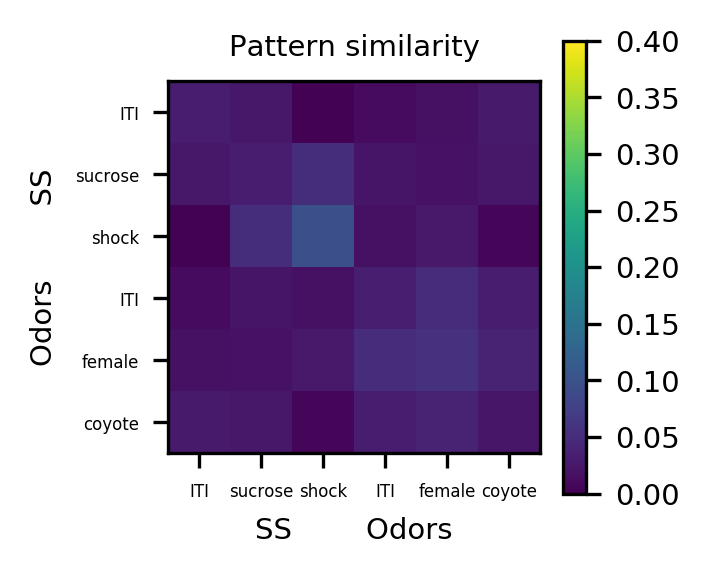

In [23]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))

# im = ax.imshow(corrmat, vmin=0.14, vmax=0.26)
im = ax.imshow(corrmat, vmin=0., vmax=0.4)
ax.set_yticks(range(len(all_patterns)))
ax.set_xticks(range(len(all_patterns)))
ax.set_xticklabels(['ITI', 'sucrose', 'shock', 'ITI', 'female', 'coyote'], fontsize=4)
ax.set_yticklabels(['ITI', 'sucrose', 'shock', 'ITI', 'female', 'coyote'], fontsize=4)
ax.set_xlabel('SS        Odors')
ax.set_ylabel('Odors        SS')
pl.colorbar(im)
ax.set_title('Pattern similarity', fontsize=7)
print 'unlike day1 notebook, this seems ok'

In [15]:
# fig, ax = pl.subplots(1, 1, figsize=(2, 2))

# clust_model = KMeans(2)
# cov_labels = clust_model.fit_predict(corrmat)
# print clust_score(corrmat, cov_labels)

# im = ax.imshow([c[np.argsort(cov_labels)] for c in corrmat[np.argsort(cov_labels)]],
#           aspect='auto', cmap=pl.cm.RdBu_r, vmin=-1, vmax=1)
# # ax.colorbar()
# # ax.set_xticks(())
# # ax.set_yticks(());
# ax.set_yticks(range(len(all_patterns)))
# ax.set_xticks(range(len(all_patterns)))

# labels = np.r_[['pre\nITI', 'pre\nOd1', 'pre\nOd3', 'pre\nOd5',
#                'post\nITI', 'post\nOd1', 'post\nOd3', 'post\nOd5']]

# ax.set_xticklabels(labels[np.argsort(cov_labels)], fontsize=5)
# ax.set_yticklabels(labels[np.argsort(cov_labels)], fontsize=5)
# fig.colorbar(im)
# ax.set_title('Pattern similarity', fontsize=7)

In [16]:
pattern_ids = ['SS-all', 'O-all']
all_patterns = (np.row_stack((patterns_bs_SS, patterns_reward, patterns_shock)),
                np.row_stack((patterns_bs_O, patterns_female, patterns_coyote)))
corrmat_distr_ppa, corrmat_ppa = ut.compute_similarity_matrix(pattern_ids, all_patterns)

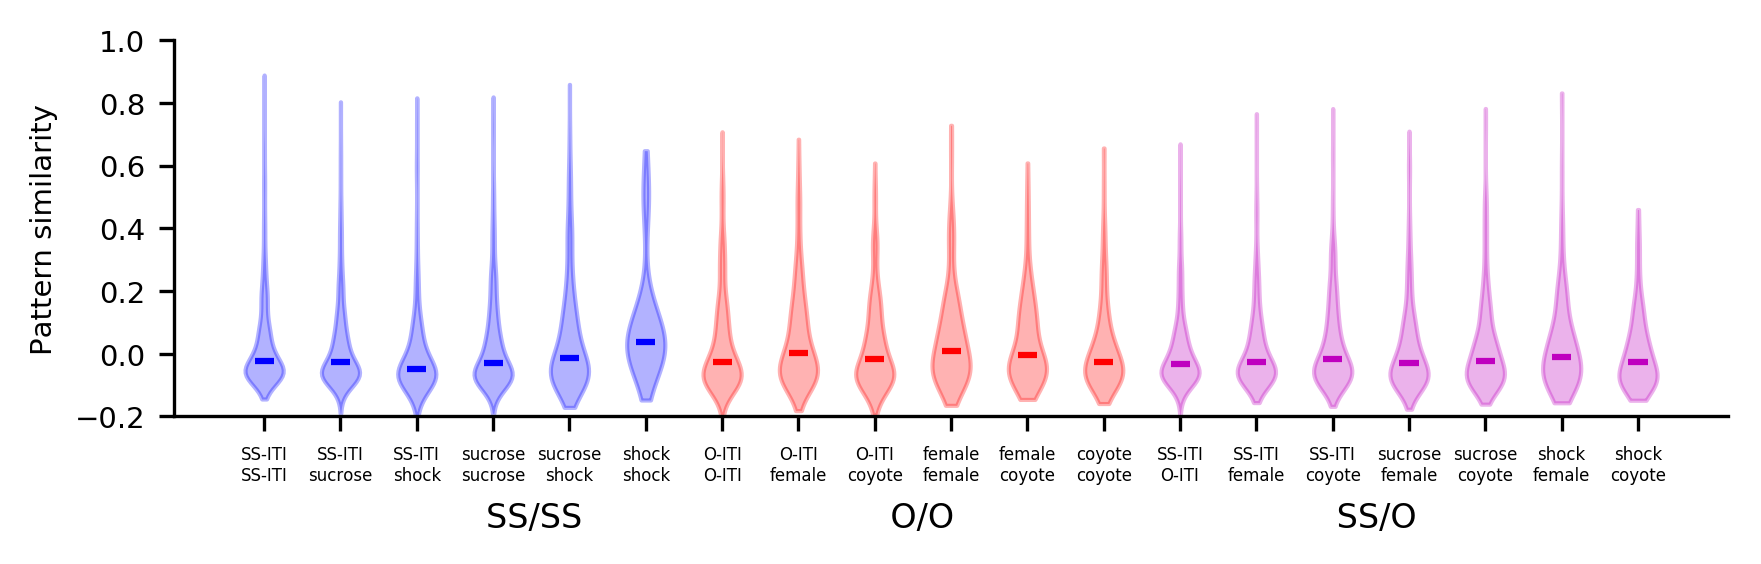

In [24]:
pairs_to_plot = [('SS-ITI', 'SS-ITI'),
                 ('SS-ITI', 'sucrose'),
                 ('SS-ITI', 'shock'),
                 ('sucrose', 'sucrose'),
                 ('sucrose', 'shock'),
                 ('shock', 'shock'),
                 ('O-ITI', 'O-ITI'),
                 ('O-ITI', 'female'),
                 ('O-ITI', 'coyote'),
                 ('female', 'female'),
                 ('female', 'coyote'),
                 ('coyote', 'coyote'),
                 ('SS-ITI', 'O-ITI'),
                 ('SS-ITI', 'female'),
                 ('SS-ITI', 'coyote'),
                 ('sucrose', 'female'),
                 ('sucrose', 'coyote'),
                 ('shock', 'female'),
                 ('shock', 'coyote')]
# colors = ['0.7', 'r', (1, 1, 0), (1, 0, 1), (0, 1, 0), (0, 1, 1), (0, 0, 1)]
colors = ['b']*6 + ['r']*6 + ['m']*7

from scipy import stats

fig, ax = pl.subplots(1, 1, figsize=(6, 2))
values = [corrmat_distr[p] for p in pairs_to_plot]
# ax = axs[0]
# pt.barplot(ax, xrange(len(values)), [np.mean(v) for v in values], [sstats.sem(v) for v in values],
#            color=colors)
# pt.plot_bars(values, ax=ax, colors=colors, stderr=True)
pt.plot_violins(values, ax=ax, colors=colors)
# pt.add_significance(ax, values[0], values[1], 0, 1, 0.5, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[1], values[2], 1, 2, 0.6, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[0], values[2], 0, 2, 0.7, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[1], values[4], 1, 4, 0.8, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[2], values[3], 2, 3, 0.3, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[3], values[5], 3, 5, 0.7, thresholds=(1e-3, 1e-4, 1e-5))
ax.set_xticks(range(len(values)))
ax.set_xticklabels(['%s\n%s'%(p[0][:], p[1][:]) for p in pairs_to_plot], fontsize=4)
ax.set_xlabel('SS/SS                             O/O                                    SS/O', fontsize=8)
ax.set_ylim(-0.2, 1)
ax.set_ylabel("Pattern similarity")
pt.nicer_plot(ax)

fig.tight_layout()
pl.savefig("pattern_similarity_SSOd2_violin.jpg", format="jpg", bbox_inches="tight")

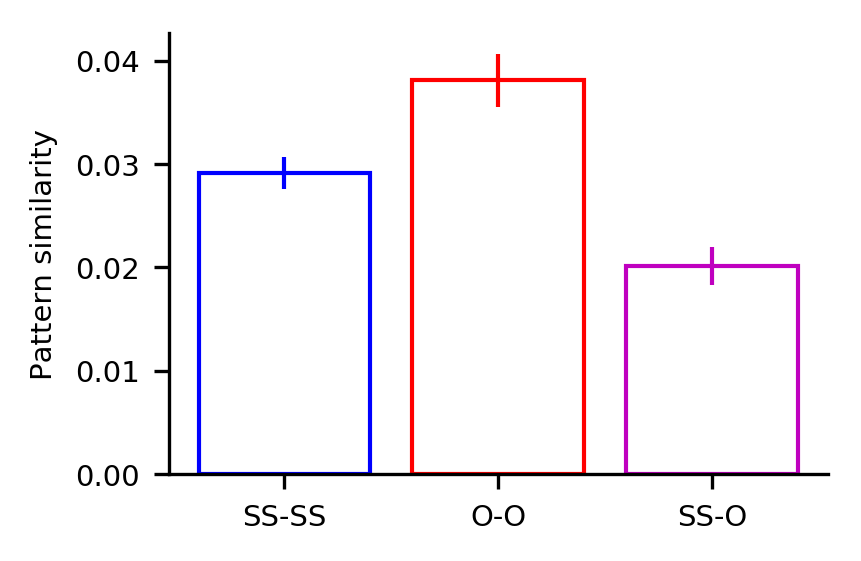

In [18]:
pairs_to_plot = [('SS-all', 'SS-all'),
                 ('O-all', 'O-all'),
                 ('SS-all', 'O-all')]
# colors = ['0.7', 'r', (1, 1, 0), (1, 0, 1), (0, 1, 0), (0, 1, 1), (0, 0, 1)]
colors = ['b'] + ['r'] + ['m']

fig, ax = pl.subplots(1, 1, figsize=(3, 2))
values = [corrmat_distr_ppa[p] for p in pairs_to_plot]
# ax = axs[0]
pt.plot_bars(values, colors=colors,  stderr=True, ax=ax)
# pt.add_significance(ax, values[0], values[1], 0, 1, 0.5, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[1], values[2], 1, 2, 0.6, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[0], values[2], 0, 2, 0.7, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[1], values[4], 1, 4, 0.8, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[2], values[3], 2, 3, 0.3, thresholds=(1e-3, 1e-4, 1e-5))
# pt.add_significance(ax, values[3], values[5], 3, 5, 0.7, thresholds=(1e-3, 1e-4, 1e-5))
ax.set_xticks(range(len(values)))
ax.set_xticklabels(['SS-SS', 'O-O', 'SS-O'], fontsize=7)
# ax.set_xlabel('Pre/Pre                             Post/Post                                    Pre/Post', fontsize=8)
# ax.set_ylim(-0.2, .9)
ax.set_ylabel("Pattern similarity")
pt.nicer_plot(ax)

fig.tight_layout()

In [19]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'stats'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'json'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
